In [132]:
import requests
import json
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
from sklearn import decomposition
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [3]:
stat_url = "https://api.wotblitz.ru/wotb/encyclopedia/vehicles/?application_id=77636487a299e95a72583de66dba7a63"
response = json.loads(requests.get(stat_url).text)["data"]

In [4]:
def convert_to_array(data):
    cost_credit = None
    cost_gold = None
    if (data["cost"]):
        cost_credit = data["cost"]["price_credit"]
        cost_gold = data["cost"]["price_gold"]
        if cost_credit == 0:
            cost_credit = cost_gold * 400
    
    return [#data["tank_id"],
            data["name"]
            ,data["type"]
            ,data["nation"]
            ,data["tier"]
            ,1 if data["is_premium"] else 0
            ,cost_credit
#             ,cost_gold
            ,data["default_profile"]["weight"]
            ,data["default_profile"]["firepower"]
            ,data["default_profile"]["shot_efficiency"]
            ,data["default_profile"]["protection"]
            ,data["default_profile"]["maneuverability"]
            ,data["default_profile"]["speed_forward"]
            ,data["default_profile"]["speed_backward"]
            ,data["default_profile"]["max_ammo"]
            ,data["default_profile"]["hp"]
    
           ]

In [198]:
all_raw_data = [convert_to_array(x) for x in response.values()]

In [199]:
data = pd.DataFrame(all_raw_data, index=response.keys() , columns = ["name", "type", "nation", "tier", "is_prem", "price_credit", 
                                             "weight", "firepower", "shot_efficiency", "protection",
                                            "maneuverability", "speed_forward", "speed_backward", "max_ammo",
                                            "hp"])

In [200]:
nation_columns = pd.get_dummies(data["nation"])

In [201]:
pd.Categorical(data["type"]).categories

Index(['AT-SPG', 'heavyTank', 'lightTank', 'mediumTank'], dtype='object')

In [202]:
type_column = pd.Categorical(data["type"]).codes

In [203]:
data["type"] = type_column
# data = pd.concat([data.drop(["nation"], axis=1), nation_columns], axis=1)
data = data.drop(["nation"], axis=1)

In [204]:
# data = data.drop(["name"], axis=1)

In [205]:
data.shape

(328, 14)

In [206]:
data.head()

,name,type,tier,is_prem,price_credit,weight,firepower,shot_efficiency,protection,maneuverability,speed_forward,speed_backward,max_ammo,hp
14865,Leopard Prototyp A,3,9,0,3450000.0,39168,61,74,40,52,65,23,90,1550
54273,СУ-76И,0,3,1,400000.0,22780,10,30,14,51,50,14,98,300
5377,ИС-3,1,8,0,2568500.0,48675,40,53,63,31,38,15,28,1450
6417,Pz.Kpfw. III/IV,3,5,0,315000.0,23817,24,37,22,43,55,18,87,620
17,Pz.Kpfw. IV,3,5,0,373000.0,24617,24,37,20,38,48,18,87,660


# Fill NA

In [207]:
avg_price_by_tier = (data
                     .groupby(['tier'])["price_credit"]
                     .mean()
                     .to_dict()
                     )

In [208]:
b = data[data["price_credit"].isna()]["tier"].apply(lambda x: avg_price_by_tier[x])
data["price_credit"].fillna(b, inplace=True)

In [220]:
data_sampled = data#[data["tier"] == 8]
y = data_sampled["type"]
X = data_sampled.drop(["type", "name"], axis=1)

In [221]:
tier = data["tier"]

# PCA

In [222]:
pca = decomposition.PCA(n_components=2)

In [223]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled

In [224]:
X_pca = pca.fit_transform(X_scaled)

In [232]:
pca.explained_variance_ratio_

array([0.51358867, 0.21670547])

# T-SNE

In [225]:
from sklearn.manifold import TSNE

In [226]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_scaled)

# Draw

In [227]:
fig = plt.figure(1, figsize=(6, 5))
plt.clf()

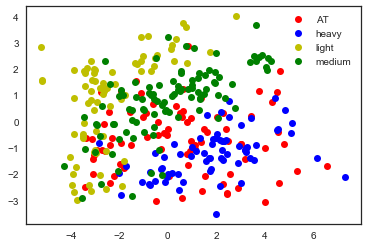

In [234]:
plt.plot(X_pca[y==0, 0], X_pca[y==0, 1], 'ro', label="AT")
plt.plot(X_pca[y==1, 0], X_pca[y==1, 1], 'bo', label="heavy")
plt.plot(X_pca[y==2, 0], X_pca[y==2, 1], 'yo', label="light")
plt.plot(X_pca[y==3, 0], X_pca[y==3, 1], 'go', label="medium")
plt.legend(loc=0)

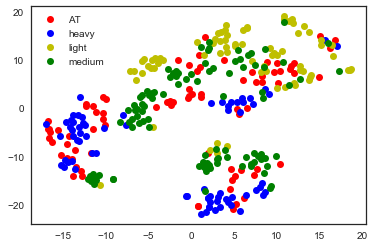

In [238]:
plt.plot(X_tsne[y==0, 0], X_tsne[y==0, 1], 'ro', label="AT")
plt.plot(X_tsne[y==1, 0], X_tsne[y==1, 1], 'bo', label="heavy")
plt.plot(X_tsne[y==2, 0], X_tsne[y==2, 1], 'yo', label="light")
plt.plot(X_tsne[y==3, 0], X_tsne[y==3, 1], 'go', label="medium")
plt.legend(loc=0)

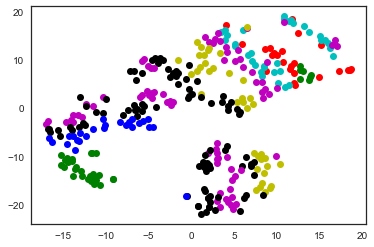

In [230]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'm', 'k', 'b', 'g']

for i in range(1,11):
    plt.plot(X_tsne[tier==i, 0], X_tsne[tier==i, 1], colors[i]+ "o", label=str(i))

In [231]:
kmeans = KMeans(n_clusters=8)
X_kmeans = kmeans.fit(X_tsne)

In [ ]:
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=kmeans.labels_, s=20,  cmap='viridis');

In [ ]:
data[kmeans.labels_==1]

In [248]:
pd.DataFrame([scaler.inverse_transform(pca.inverse_transform([2,2])),
             scaler.inverse_transform(pca.inverse_transform([4,3]))], columns = X.columns)

,tier,is_prem,price_credit,weight,firepower,shot_efficiency,protection,maneuverability,speed_forward,speed_backward,max_ammo,hp
0,8.549389,0.359990,3.400635e+06,42537.255097,59.916380,68.844408,47.162555,55.645526,57.850284,20.485863,54.684644,1464.489433
1,10.743715,0.394496,4.890584e+06,53971.609539,77.159245,88.070615,62.572125,60.176039,63.574137,22.636217,13.929099,1910.065151


In [251]:
pd.DataFrame([scaler.inverse_transform(pca.mean_)], columns = X.columns)

,tier,is_prem,price_credit,weight,firepower,shot_efficiency,protection,maneuverability,speed_forward,speed_backward,max_ammo,hp
0,6.027439,0.301829,1.691738e+06,34958.579268,40.515244,47.051829,32.926829,41.64939,44.783537,15.890244,94.021341,977.14939


In [261]:
data["tier"].hist()

In [283]:
ttt= data["tier"]

In [268]:
data.shape

(328, 14)

In [282]:
# data["speed_forward"].hist()
# data["speed_backward"].hist()

import seaborn as sns

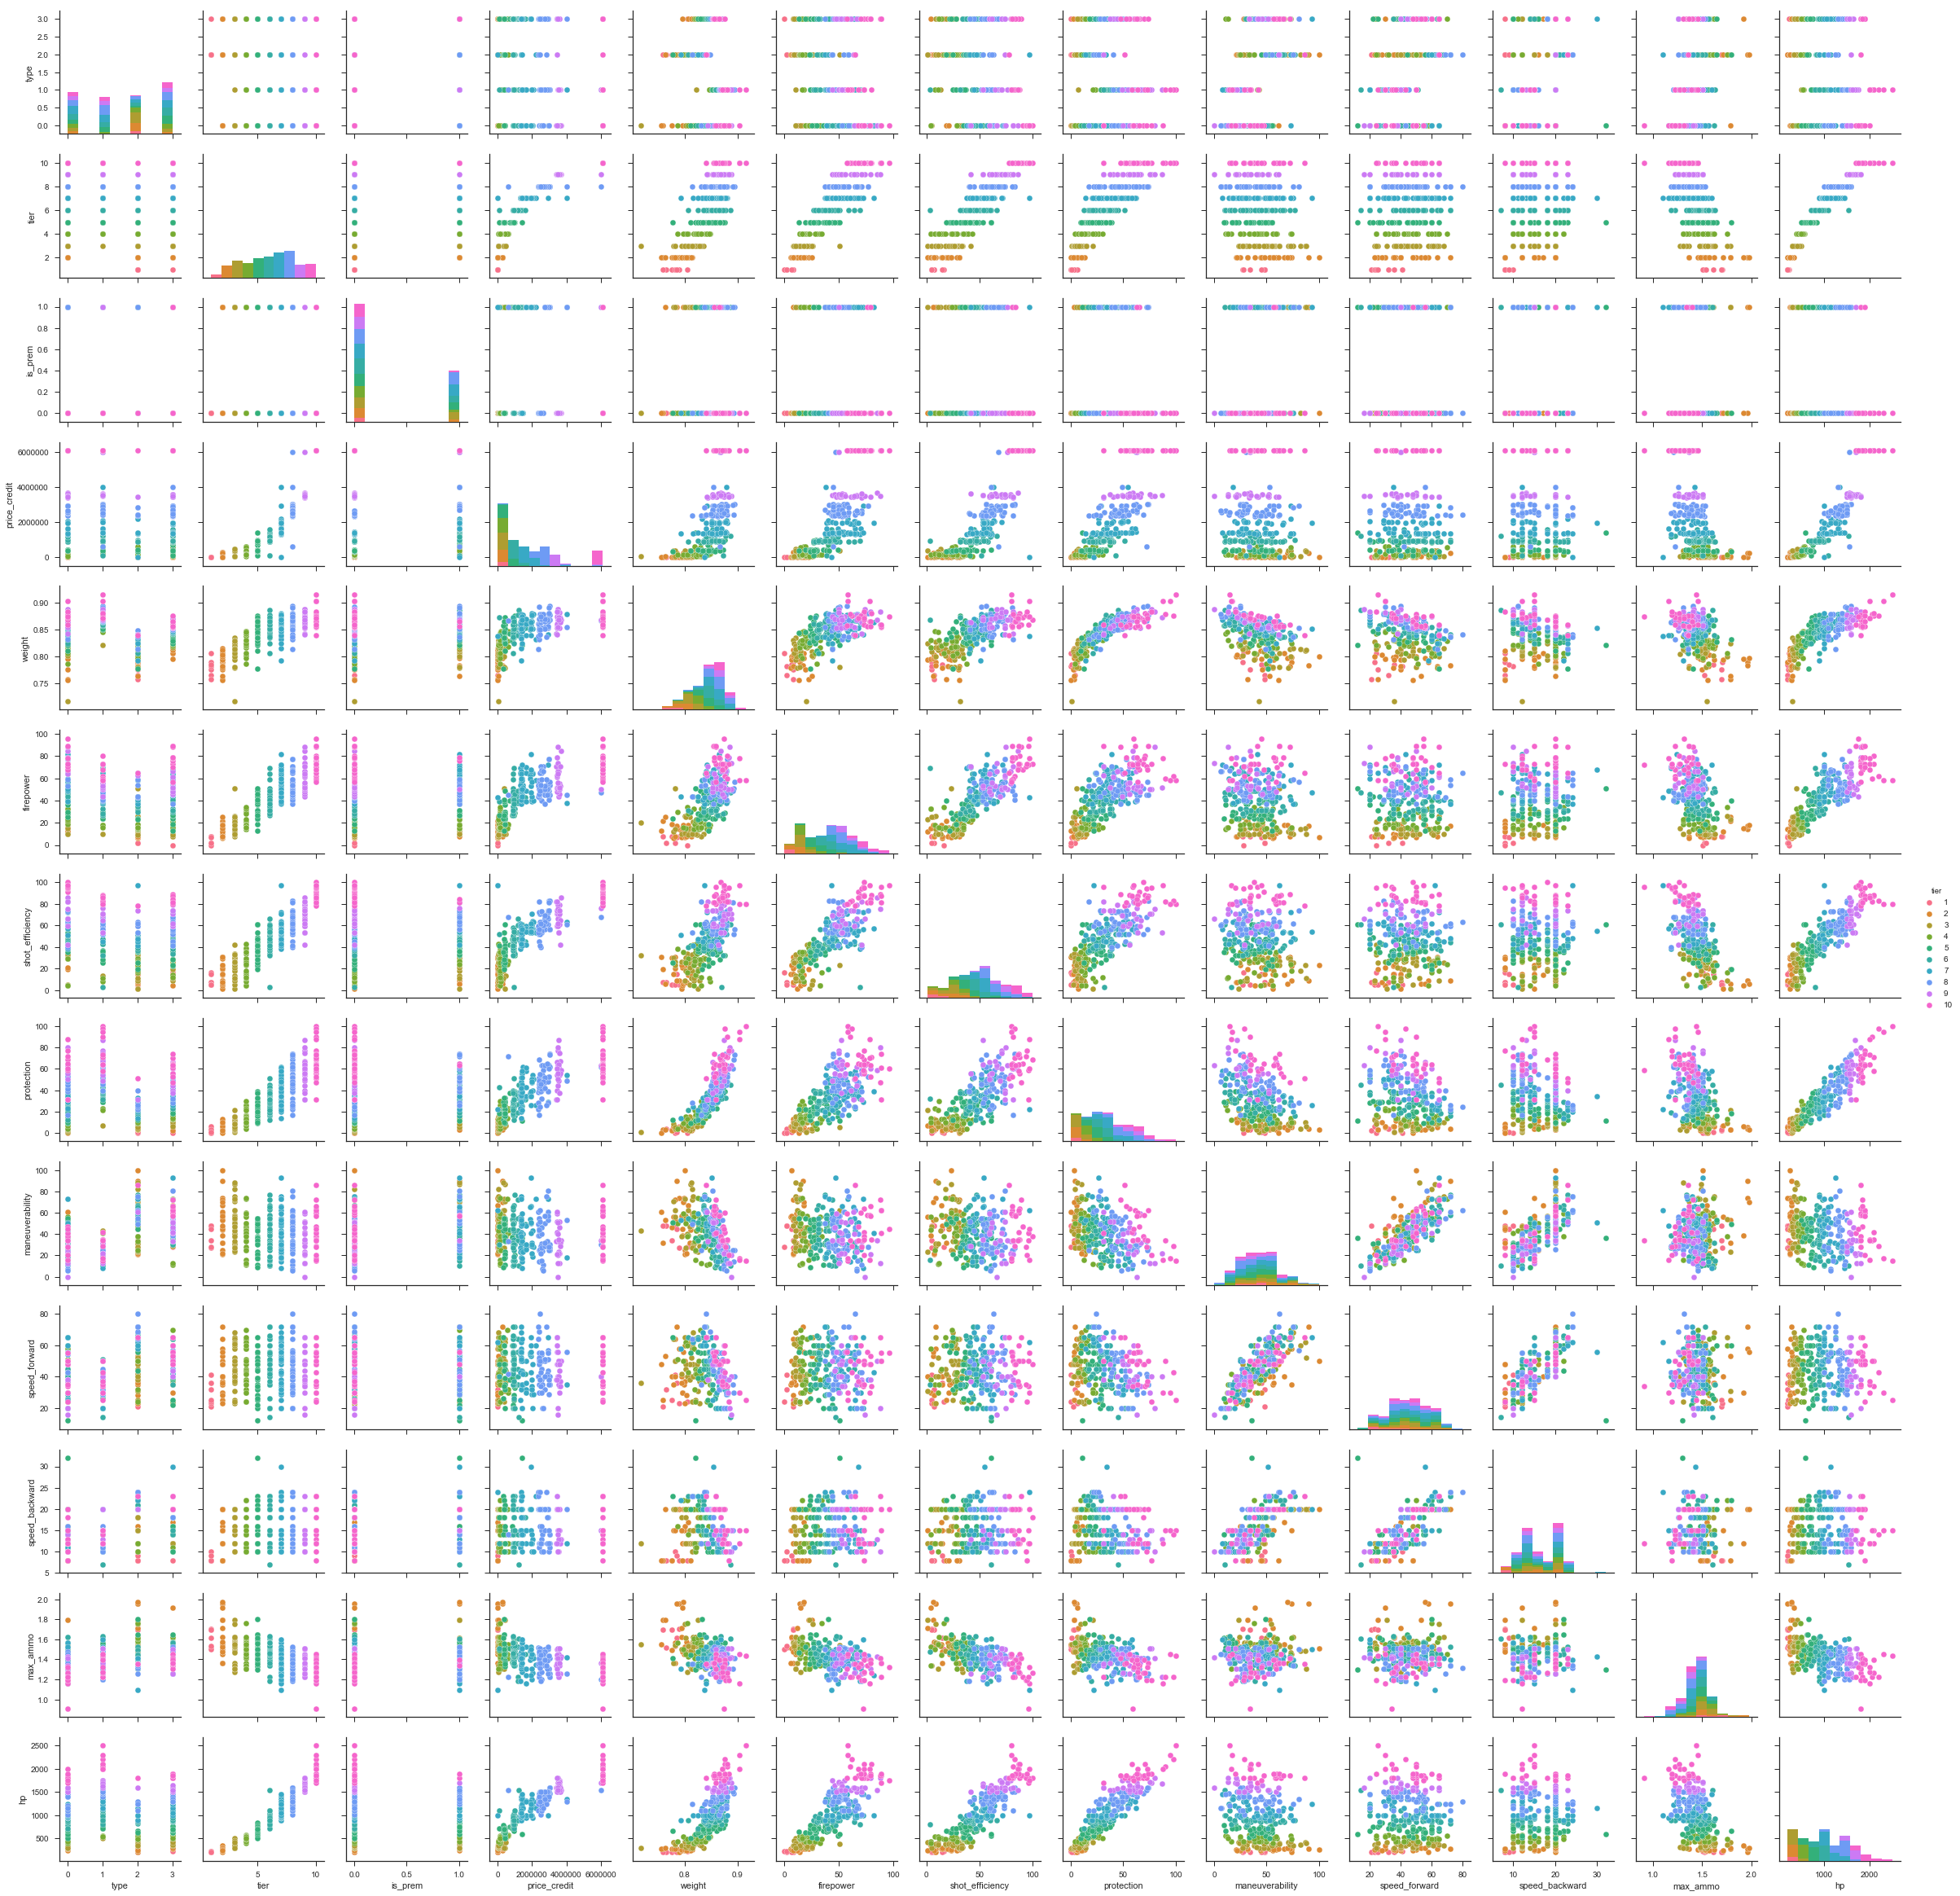

In [292]:
data2 = data
data2["weight"] = np.log(data["weight"]) 
data2["max_ammo"] = np.log(data["max_ammo"])
sns.pairplot(data2, hue="tier")

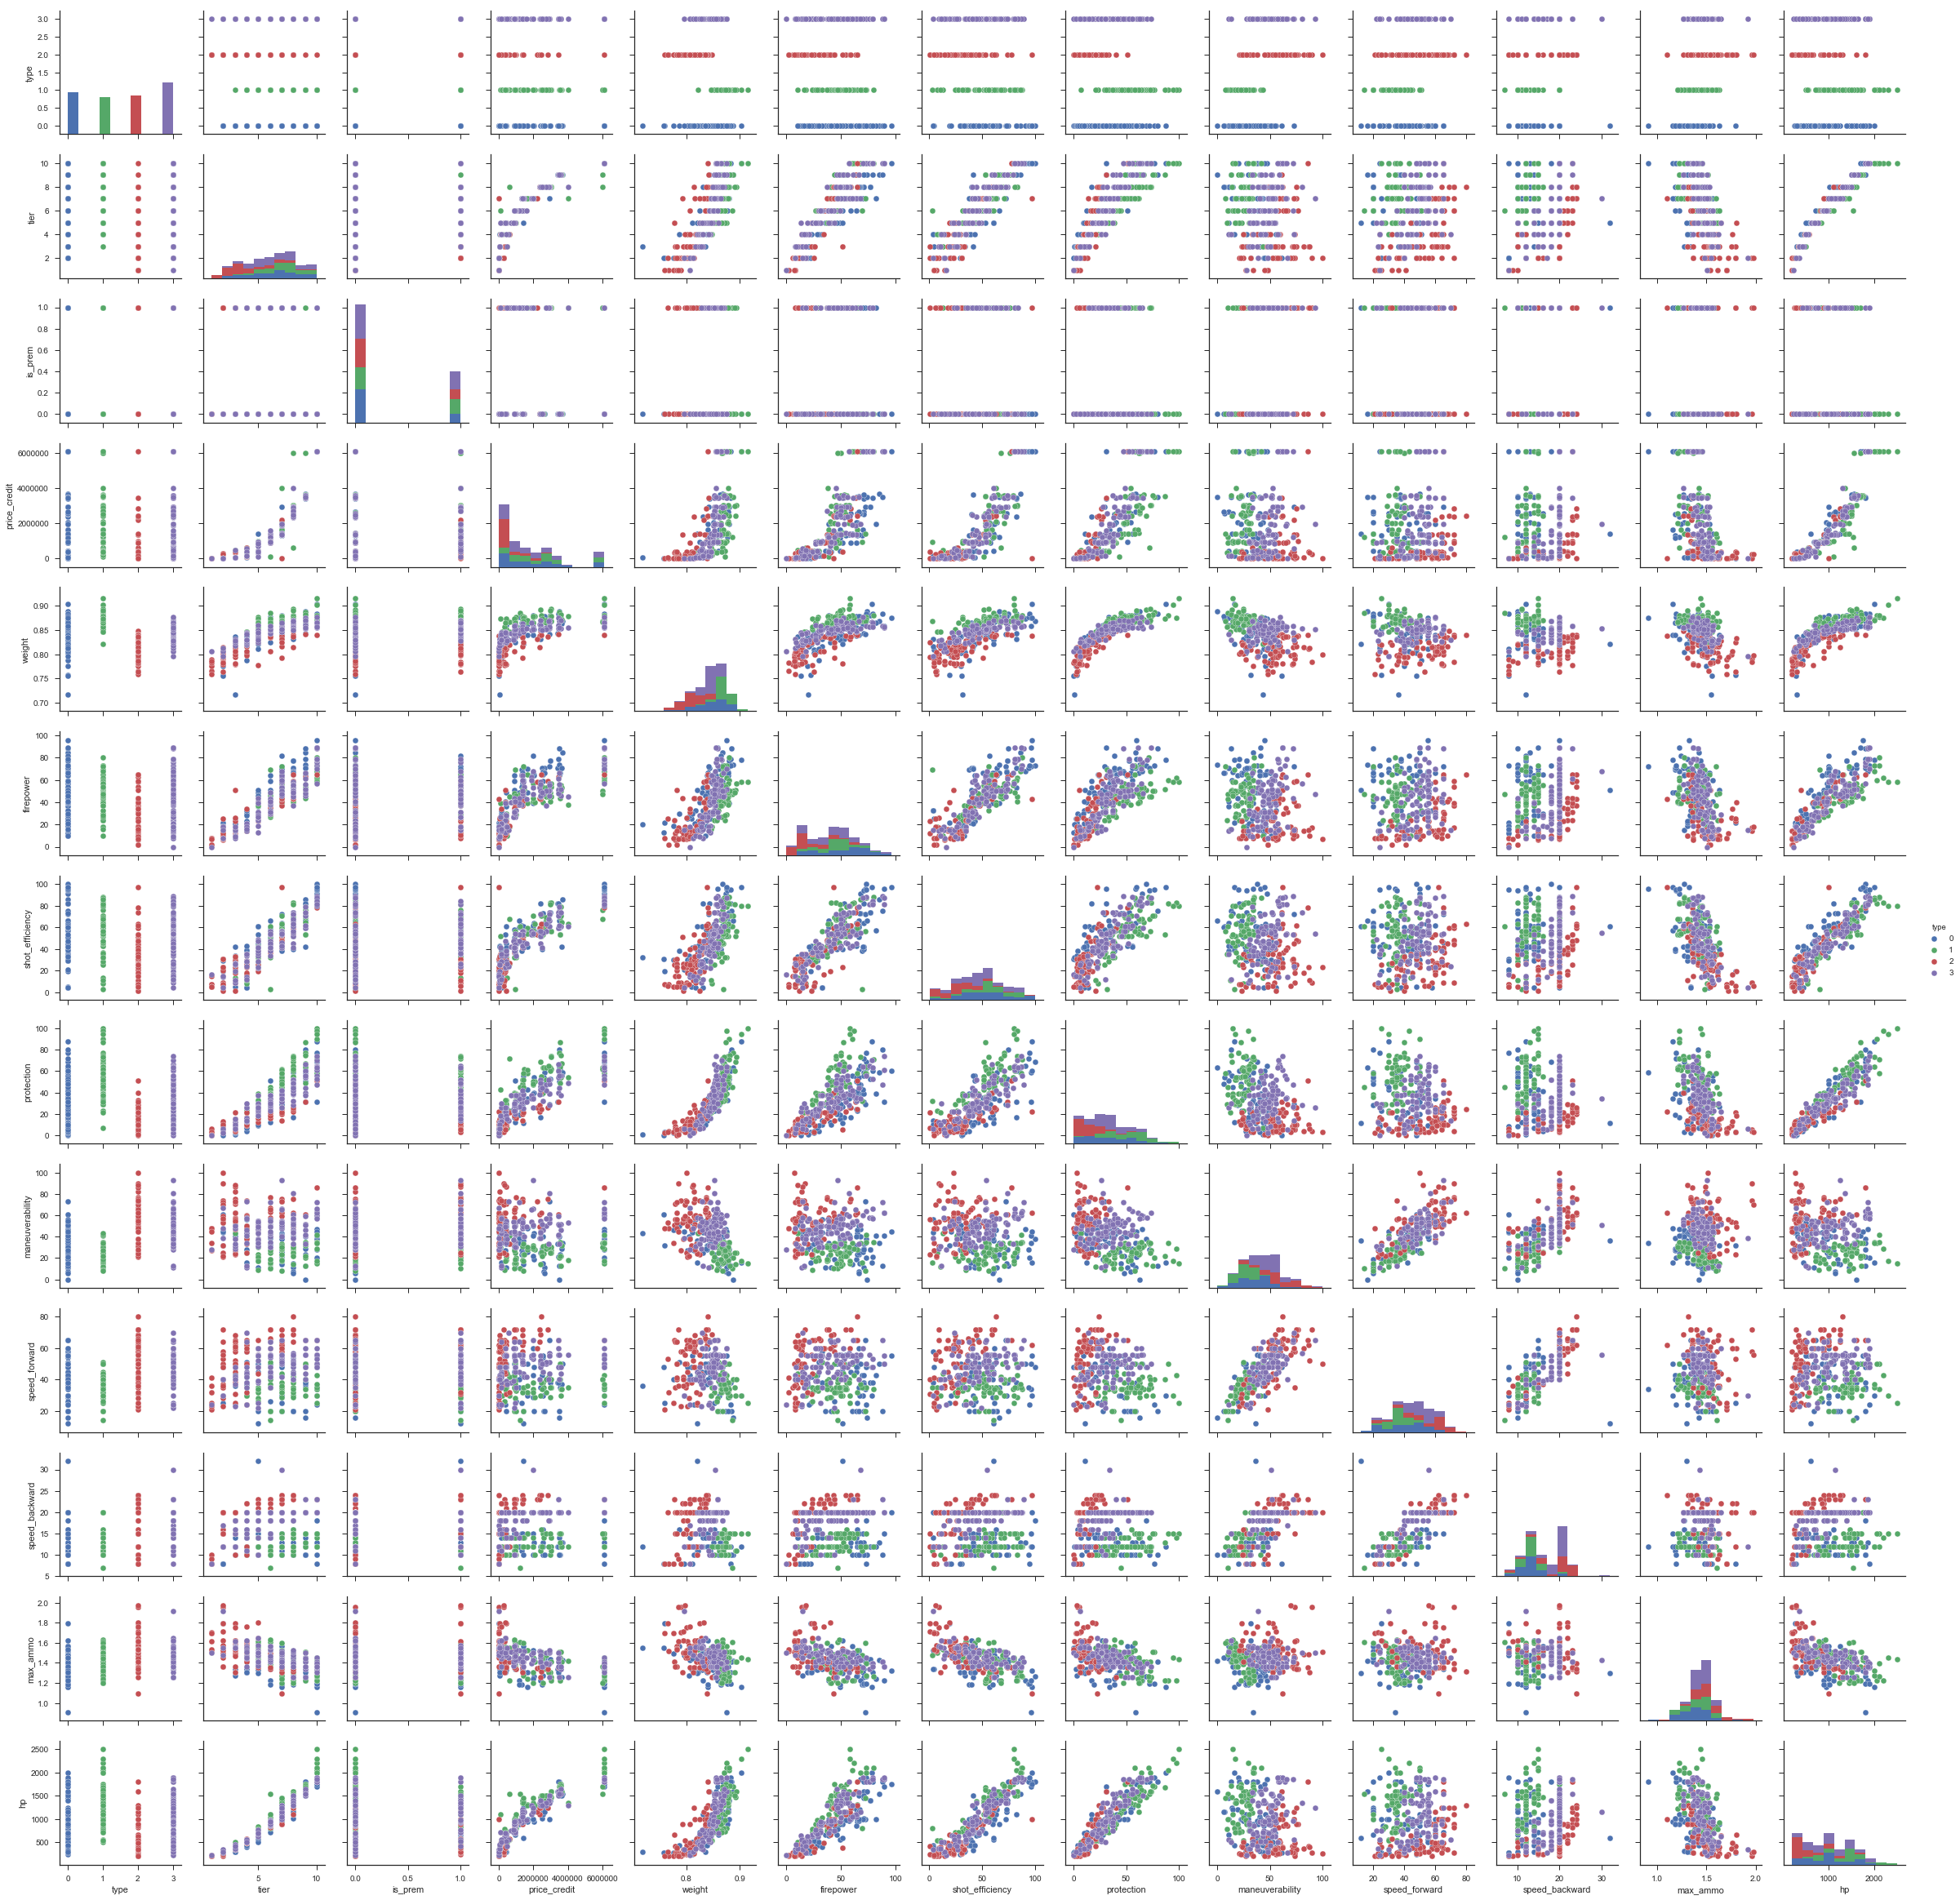

In [293]:
sns.pairplot(data2, hue="type")